# Analysis of the LLM Runs
This will use the the event_study file to analyse the performance across the different strategies. The strategies tested in this file are:

- Base case (consensus estimates from Wall Street analysts on the sellside)
- Llama (zero shot)
- Llama (chain of thought)

In [1]:
# Install signal_lab if it isn't already loaded
%package install bloomberg.bquant.signal_lab=1.5.2

Running: micromamba install bloomberg.bquant.signal_lab=1.5.2 --yes --quiet --log-level=error

Note: Packages not from Bloomberg channels are not vetted by Bloomberg.
Please restart the Jupyter kernel if you run into any issues after installing or updating packages via %package.



In [2]:
import json
import pandas as pd
import numpy as np
import importlib
import os

import event_study as es
import utils.tradegeneration as tg

from bloomberg.bquant.signal_lab.workflow.utils import get_sandbox_path
from backtest_params import get_analyst_params, get_universe_params

from prompts import SYSTEM_PROMPTS

import plotly.express as px

datapack_path = f"{get_sandbox_path()}/tmp/fs/datapack"

In [3]:
datapack_path

's3://awmgd-prod-finml-02-sandbox-user/bclarke16/tmp/fs/datapack'

In [4]:
importlib.reload(es)
importlib.reload(tg)

<module 'utils.tradegeneration' from '/project/utils/tradegeneration.py'>

## Base case

This is used as the baseline and is the consensus estimates based on Wall Street sellside analysts. The recommendations are aggregated across a number of analysts. If the rating is 5, this is a strong buy, if the rating is a 1, this is a strong sell. 

In [5]:
# STEP 1: Get the data 
start = '2020-02-07'
end = '2024-12-31'
universe_name = 'INDU Index'
universe, benchmark, trading_calendar = get_universe_params(start, end, universe_name, datapack_path)
analyst_ratings = get_analyst_params(start, end, datapack_path)

In [7]:
analyst_ratings.bind_universe(universe)
ratings_df = analyst_ratings.df().ffill()


100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


In [48]:
ids = universe.df().columns


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


In [51]:
ids

Index(['BBG000B9XRY4', 'BBG000BBJQV0', 'BBG000BBS2Y0', 'BBG000BCQZS4',
       'BBG000BCSST7', 'BBG000BF0K17', 'BBG000BH4R78', 'BBG000BJ81C1',
       'BBG000BKZB36', 'BBG000BLNNH6', 'BBG000BMHYD1', 'BBG000BMX289',
       'BBG000BN2DC2', 'BBG000BNSZP1', 'BBG000BP52R2', 'BBG000BPD168',
       'BBG000BPH459', 'BBG000BR2B91', 'BBG000BR2TH3', 'BBG000BSXQV7',
       'BBG000BVPV84', 'BBG000BW8S60', 'BBG000BWLMJ4', 'BBG000BWXBC2',
       'BBG000C0G1D1', 'BBG000C3J3C9', 'BBG000C5HS04', 'BBG000C6CFJ5',
       'BBG000CH5208', 'BBG000DMBXR2', 'BBG000GZQ728', 'BBG000H556T9',
       'BBG000HS77T5', 'BBG000K4ND22', 'BBG000PSKYX7', 'BBG00BN96922'],
      dtype='object', name='ID')

In [39]:
# STEP 2: Convert the recommendations into a list of trades
def rating(rating: float) -> int:
    if rating > 3.5:
        return 1
    if rating < 3.0:
        return -1
    else:
        return 0

def trade_direction(trade: int) -> str:
    if trade == 1:
        return "BUY"
    if trade == -1:
        return "SELL"
    else:
        return "HOLD"

def convert_to_trade_view(df: pd.DataFrame) -> pd.DataFrame:
    trade_dfs = []
    # loop through each column
    for security in ratings_df.columns:
        # convert to a numerical buy/ sell/ hold
        df[security] = df[security].apply(rating)
        diff_df = df[[security]]
        diff_df['diff'] = diff_df[security].diff().fillna(1)
        # look for where the rating has changed and filter on this date
        trade_df = diff_df[diff_df['diff'] != 0]
        # change back to BUY/ SELL/ HOLD
        trade_df[security] = trade_df[security].apply(trade_direction)
        # reformat the dataframe so that it is Date | Security | trade direction
        trade_df['Security'] = security
        final_df = trade_df.reset_index().rename(columns={security:'Decision', 'DATE':'Date'})[['Date','Security', 'Decision']].reset_index()
        trade_dfs.append(final_df)
    return pd.concat(trade_dfs)

trade_analyst_recommendations = convert_to_trade_view(ratings_df.copy(deep=True)).sort_values('Date')

In [41]:
trade_analyst_recommendations.to_csv('analyst_ratings.csv')

In [40]:
# STEP 3: Backtest the strategy using the EventBacktester
backtest = es.EventBacktest(start=start, 
                            end=end, 
                            universe_name=universe_name, 
                            data_pack_path=datapack_path)
results = backtest.run(trade_analyst_recommendations, 'base')


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]

100%|██████████| 117/117 [00:38<00:00,  3.02it/s]


In [42]:
df_strategy_return, df_benchmark_return = backtest.get_return_data()

In [43]:
df_chart = df_strategy_return.merge(df_benchmark_return, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)_x': 'Return - BASE', 'Cum. Return (Gross)_y':'Return - Benchmark'})[['Return - BASE','Return - Benchmark']]

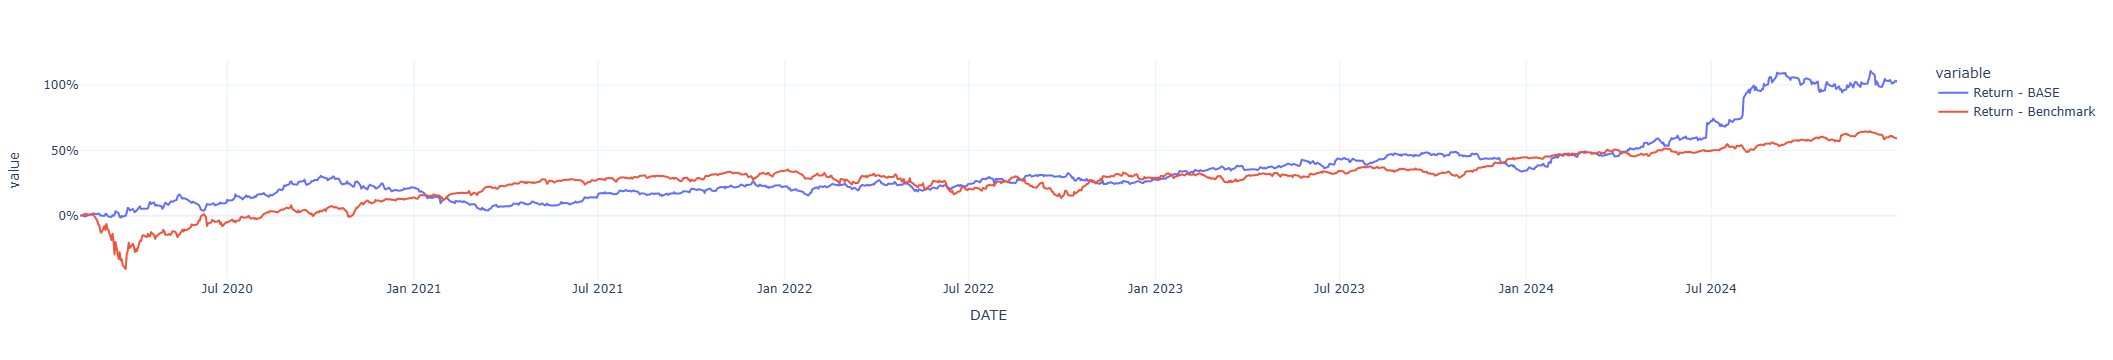

In [44]:
fig = px.line(df_chart)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

## LLM Strategies

Loop through each of the strategies in results. 

In [13]:
# STEP 1: Go through the saved results in the Results folder and generate the trade reports
def find_prompt_type(prompt):
    for prompt_type in SYSTEM_PROMPTS.keys():
        if SYSTEM_PROMPTS[prompt_type]['prompt'] == prompt:
            return prompt_type
    return None


results = {}
# Loop through all of the results 
for file in os.listdir('Results'):
    # filter out the non-json files in the folder
    if file[-5:] == '.json':
        
        with open(f'Results/{file}', 'rb') as f:
            result = json.load(f)
            # find the system prompt to add into the name
            prompt_type = find_prompt_type(result['system_prompt'])
            # store the trade report in the results dictionary
            results[f"{result['model']} - {prompt_type}"] = tg.generate_trade_report(result['results'])

In [14]:
# STEP 2: Event backtest each of the results and store in the trade_results dictionary
trade_results = {}
for key in results.keys():
    trades = pd.DataFrame(results[key])
    backtest_output = backtest.run(trades,'key')
    df_strategy, df_benchmark = backtest.get_return_data()
    trade_results[key] = df_strategy


100%|██████████| 117/117 [00:41<00:00,  2.84it/s]

100%|██████████| 117/117 [00:38<00:00,  3.07it/s]

100%|██████████| 117/117 [00:37<00:00,  3.08it/s]

100%|██████████| 117/117 [00:40<00:00,  2.89it/s]

100%|██████████| 117/117 [00:38<00:00,  3.04it/s]

100%|██████████| 117/117 [00:38<00:00,  3.02it/s]

100%|██████████| 117/117 [00:36<00:00,  3.21it/s]


In [33]:
# Format the dataframes to create a single dataframe for the chart
df_baseline = df_chart.copy(deep=True)

def format_chart(trade_results, df):
    for key in trade_results.keys():
        df1 = trade_results[key][['Cum. Return (Gross)']]
        df  = df.merge(df1, left_index=True, right_index=True).rename(columns={'Cum. Return (Gross)': f'Return - {key}'})
    return df

# create a dataframe for the charts
df_charts = format_chart(trade_results, df_baseline)

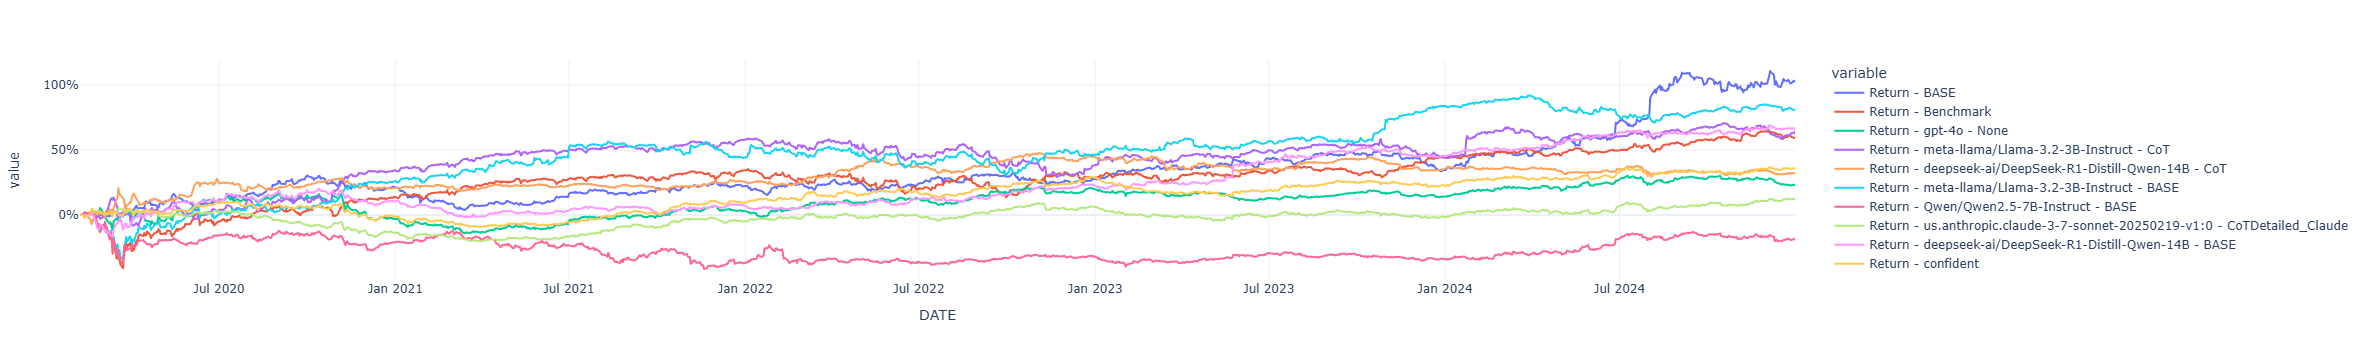

In [34]:
fig = px.line(df_charts)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

### Single Inference Strategy Analysis

In [17]:
# load the data
with open('Results/results - 2025-03-23 22:51:33.591349.json', 'rb') as file:
    base = json.load(file)

In [18]:
results = base['results']

In [19]:
trades = tg.generate_trade_report(results)
trades_df = pd.DataFrame(data=trades)

In [20]:
trades_df

,Date,Security,Decision,Confidence
0,2020-02-06,MMM UN Equity,SELL,75
1,2020-02-12,CSCO UW Equity,SELL,75
2,2020-02-12,AMGN UQ Equity,SELL,75
3,2020-02-13,AXP UN Equity,BUY,80
4,2020-02-13,NVDA UQ Equity,BUY,85
...,...,...,...,...
891,2025-01-31,XOM UN Equity,SELL,75
892,2025-02-04,PFE UN Equity,BUY,70
893,2025-02-04,MRK UN Equity,BUY,75
894,2025-02-04,AMGN UW Equity,BUY,75


In [ ]:

def explore_data(df):
    #print("Number Missing: ", df['Decision'].value_counts()['Missing'])
    print("Number of Buy: ", df['Decision'].value_counts()['BUY'])
    print("Number of Sell: ", df['Decision'].value_counts()['SELL'])
    print("Number of Hold: ", df['Decision'].value_counts()['HOLD'])

In [ ]:
trades_df['Decision'].value_counts()['SELL']

In [ ]:
explore_data(trades_df)

In [ ]:
backtest = es.EventBacktest(start=start, 
                            end=end, 
                            universe_name=universe_name, 
                            data_pack_path=datapack_path)
backtest_output = backtest.run(trades_df, 'claude - 0.5')

In [ ]:
df_strategy, df_benchmark = backtest.get_return_data()
trade_results['claude - 0.7']

In [28]:
confident_trades = trades_df[trades_df['Confidence'] >= 80]

array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

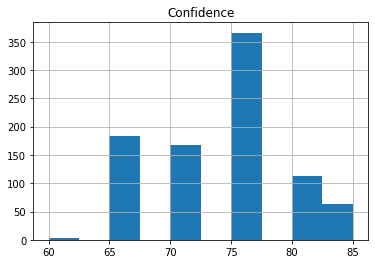

In [29]:
trades_df.hist(column='Confidence')

In [30]:
backtest_output = backtest.run(confident_trades, 'confident')


100%|██████████| 117/117 [00:38<00:00,  3.02it/s]


In [31]:
df_strategy, df_benchmark = backtest.get_return_data()

In [32]:
trade_results['confident'] = df_strategy

In [45]:
results.plot_analytics()